In [22]:
import syndat
import os
import numpy as np
from matplotlib.pyplot import *
# import nuctools as nuc
import pandas as pd
import scipy.linalg as spla

In [23]:
%matplotlib widget

### This notebook uses the syndat program to create a synthetic realization of the Ta181 transmission data set using ENDF parameters and verifies the results against real data reduced by Brown, et. al.

Because the we are using the endf evaluated parameters, we are skipping the steps to generate resonance paremeters and theoretical tranmission with syndat. Rather, we will just read out the sammy calculated endf cross section and take that as the true theoretical cross section.

In [24]:
opendata = '../synthetic_data/Ta181/rpi-open-ta181.csv'
sammy_xs = '../synthetic_data/Ta181/endf_eval/SAMMY.LST'
JBrown_lst = syndat.sammy_interface.readlst('../synthetic_data/Ta181/JB_sol/SAMMY_JBsol.LST')
JBrown_lst['tof'] = syndat.exp_effects.e_to_t(JBrown_lst.E, 35.185, True)*1e6+3.326

In [25]:
# generation/reduction options
perform_methods = True
add_noise = True
default_exp = True

experiment = syndat.experiment(perform_methods, default_exp, add_noise, opendata, sammy_xs)
experiment.odat

,tof,bin_width,c,dc,E,bw,cps,dcps
0,3.6896,0.8192,2.474461e+06,1573.041876,5.313697e+07,8.192000e-07,309461.442438,196.728038
1,4.5088,0.8192,4.441978e+04,210.760007,4.659825e+06,8.192000e-07,5555.234342,26.358105
2,5.3280,0.8192,6.956984e+04,263.760949,1.618690e+06,8.192000e-07,8700.555298,32.986518
3,6.1472,0.8192,8.332896e+04,288.667567,8.140801e+05,8.192000e-07,10421.301508,36.101394
4,6.9664,0.8192,1.211215e+05,348.025094,4.886650e+05,8.192000e-07,15147.713941,43.524775
...,...,...,...,...,...,...,...,...
16041,2153.4496,52.4288,6.957880e+03,83.413906,1.399729e+00,5.242880e-05,13.596368,0.162999
16042,2205.8784,52.4288,6.889147e+03,83.000888,1.333885e+00,5.242880e-05,13.462059,0.162192
16043,2258.3072,52.4288,6.699209e+03,81.848693,1.272579e+00,5.242880e-05,13.090900,0.159940
16044,2310.7360,52.4288,6.460441e+03,80.376870,1.215406e+00,5.242880e-05,12.624326,0.157064


In [26]:
# 

experiment.odat['E_new'] = syndat.exp_effects.t_to_e((experiment.odat.tof-experiment.redpar.val.t0)*1e-6, experiment.redpar.val.tof_dist, True) 

experiment.trans[experiment.odat['tof']<13]
# JBrown_lst

# 0.4128 + 3.326

,tof,E,theo_trans,exp_trans,exp_trans_unc
0,3.6896,5.313697e+07,0.999199,0.999628,0.024133
1,4.5088,4.659825e+06,0.972832,0.973297,0.029204
2,5.3280,1.618690e+06,0.890059,0.893185,0.024209
3,6.1472,8.140801e+05,0.678586,0.678967,0.018043
4,6.9664,4.886650e+05,0.560548,0.558517,0.014358
5,7.7856,3.255402e+05,0.497230,0.498538,0.012501
6,8.6048,2.323065e+05,0.460473,0.457871,0.011482
7,9.4240,1.740670e+05,0.437456,0.438990,0.012452
8,10.2432,1.352707e+05,0.422137,0.422541,0.013441
9,11.0624,1.081354e+05,0.411438,0.415188,0.013779


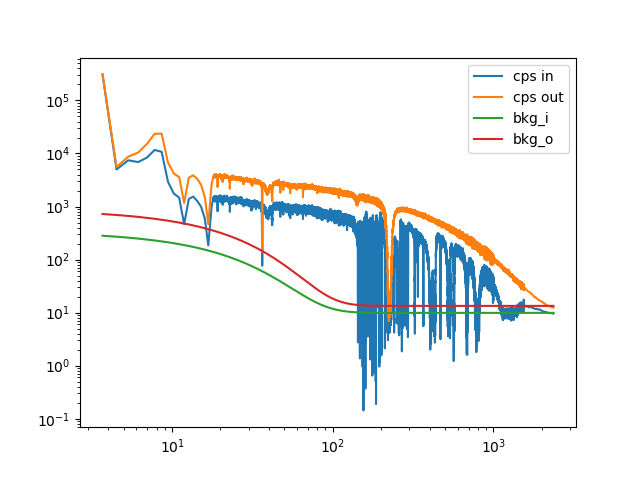

In [39]:
trans = experiment.trans
cov = experiment.CovT
tof = experiment.trans.tof

figure()
plot(trans.tof,experiment.sdat.cps, label='cps in'); 
plot(trans.tof,experiment.odat.cps, label='cps out'); 
xscale('log'); yscale('log')
plot(trans.tof, experiment.redpar.val.ks*experiment.Bi+experiment.redpar.val.b0s, label='bkg_i')
plot(trans.tof, experiment.redpar.val.ko*experiment.Bi+experiment.redpar.val.b0o, label='bkg_o')
# ylim([10,1e5])
legend()

Text(0.5, 1.0, 'Brown, et al.')

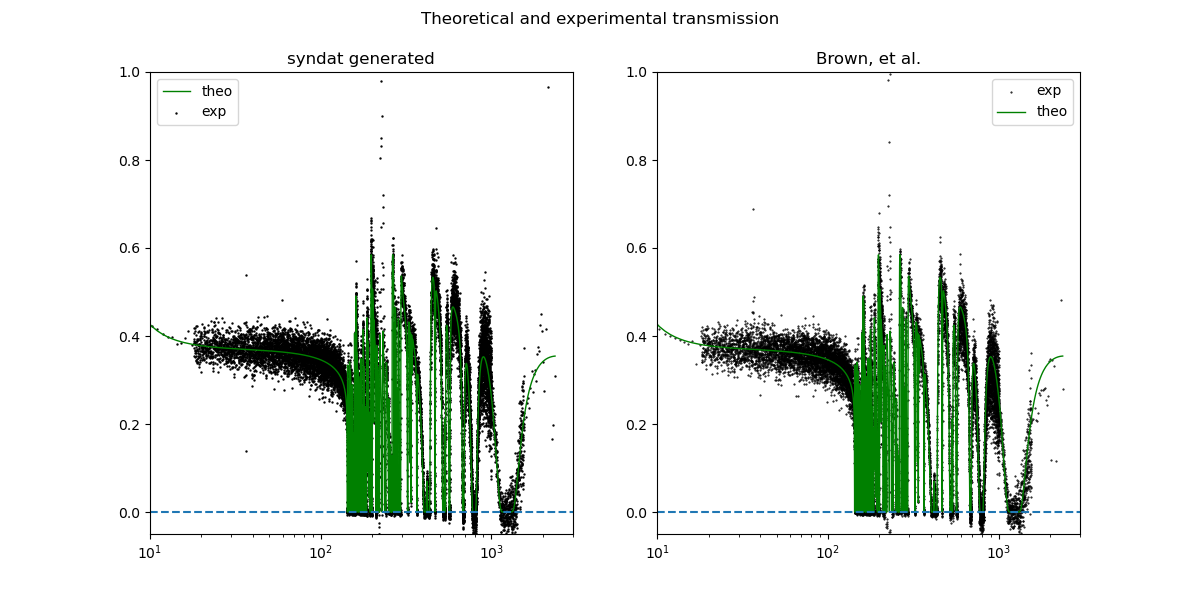

In [28]:

fig,ax = subplots(1,2, figsize=(12,6))
suptitle('Theoretical and experimental transmission')

ax[0].plot(tof,experiment.trans.theo_trans, lw=1,c='g', label='theo')
ax[0].scatter(tof,experiment.trans.exp_trans, s=0.5, c='k', label='exp')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_ylim([-0.05,1])
ax[0].set_xlim([10,3e3])
ax[0].axhline(y=0.0, ls='--')
ax[0].set_title('syndat generated')

ax[1].scatter(JBrown_lst.tof, JBrown_lst.exp_trans, marker='.', color='k', s=1, label='exp')
ax[1].plot(JBrown_lst.tof, JBrown_lst.theo_trans, lw=1,c='g', label='theo')
# ax[1].errorbar(JBrown_lst.tof, JBrown_lst.exp_trans, yerr=JBrown_lst.exp_trans_unc, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3)
ax[1].set_xscale('log')
ax[1].axhline(y=0.0, ls='--')
ax[1].set_ylim([-0.05,1])
ax[1].set_xlim([10,3e3])
ax[1].legend()
ax[1].set_title('Brown, et al.')


## Compare covariance matrix to Jesse's

This will give insight into whether or not the monitor normalizations have an effect

In [31]:
# import solution covariance 

sol_cov = np.load('../synthetic_data/Ta181/JB_sol/sol_cov.npy')

In [35]:
# figure()
# imshow(sol_cov)
# colorbar()


# itof_min = np.argwhere(np.array(experiment.trans.tof)>175)[0][0]
# itof_max = np.argwhere(np.array(experiment.trans.tof)<200)[-1][0]

# cov_oI = cov[itof_min:itof_max, itof_min:itof_max]

# figure()
# imshow(cov)
# colorbar()
print(np.shape(cov))
print(np.shape(sol_cov))

(16046, 16046)
(15915, 15915)
